In [ ]:
%cd /Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *
from utils.angle_encoding_script import angle_encoding
from utils.haar_noising_script import apply_haar_scrambling

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg
from skimage.metrics import structural_similarity as ssim_func

import pennylane as qml

/Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model


In [12]:
QG_channel = 1
num_samples = 1000

encoded_path = f"data/QG{QG_channel}_64x64_{num_samples}_encoded.pt"
scrambled_path = f"data/QG{QG_channel}_64x64_{num_samples}_scrambled.pt"

encoded_data = torch.load(encoded_path)
scrambled_states = torch.load(scrambled_path)

print(encoded_data.shape)
print(scrambled_states.shape)

train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data[:num_samples], scrambled_states, test_size=0.2, random_state=42, shuffle=True
)

torch.Size([1000, 32, 32, 4])
torch.Size([1000, 32, 32, 4])


In [20]:
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data: ensure shape is (N, C, H, W)
data = encoded_data[:num_samples]
if isinstance(data, np.ndarray):
    data = torch.tensor(data)
if data.ndim == 4:
    # (N, H, W, C) -> (N, C, H, W)
    data = data.permute(0, 3, 1, 2)
elif data.ndim == 3:
    data = data.unsqueeze(1)
data = data.float().to(device)

dataset = TensorDataset(data)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Small UNet-like model (keeps things simple)
class SmallUNet(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.down1 = nn.Sequential(nn.Conv2d(in_channels, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64,64,3,padding=1), nn.ReLU())
        self.down2 = nn.Sequential(nn.MaxPool2d(2), nn.Conv2d(64,128,3,padding=1), nn.ReLU())
        self.up1 = nn.Sequential(nn.ConvTranspose2d(128,64,2,stride=2), nn.ReLU())
        self.out = nn.Conv2d(64, in_channels, 1)
        self.time_mlp = nn.Sequential(nn.Linear(1,64), nn.ReLU(), nn.Linear(64,64))
    def forward(self,x,t):
        h1 = self.down1(x)
        h2 = self.down2(h1)
        h = self.up1(h2)
        te = self.time_mlp(t.unsqueeze(-1).float()).unsqueeze(-1).unsqueeze(-1)
        h = h + te
        out = self.out(h)
        return out

# Diffusion schedule and helpers
def get_beta_schedule(T, beta_start=1e-4, beta_end=2e-2):
    return torch.linspace(beta_start, beta_end, T)

T = 2000
betas = get_beta_schedule(T).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_acp = sqrt_alphas_cumprod[t].view(-1,1,1,1)
    sqrt_om = sqrt_one_minus_alphas_cumprod[t].view(-1,1,1,1)
    return sqrt_acp * x0 + sqrt_om * noise

loss_history = []

def p_losses(model, x0, t):
    noise = torch.randn_like(x0)
    xt = q_sample(x0, t, noise)
    pred_noise = model(xt, t.float())
    return nn.functional.mse_loss(pred_noise, noise)

# Instantiate model and optimizer
in_channels = data.shape[1]
model_ddpm = SmallUNet(in_channels).to(device)
optim = torch.optim.Adam(model_ddpm.parameters(), lr=1e-4)

num_epochs = 50
for epoch in range(num_epochs):
    model_ddpm.train()
    running = 0.0
    for batch in dataloader:
        x = batch[0].to(device)
        b = x.size(0)
        t = torch.randint(0, T, (b,), device=device)
        loss = p_losses(model_ddpm, x, t)
        optim.zero_grad(); loss.backward(); optim.step()
        running += loss.item() * b
    epoch_loss = running / len(dataset)
    loss_history.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, loss {epoch_loss:.6f}')

# Simple ancestral sampling function
@torch.no_grad()
def sample(model, n_samples):
    model.eval()
    shape = data.shape[1:]
    x = torch.randn(n_samples, *shape, device=device)
    for i in reversed(range(T)):
        t = torch.full((n_samples,), i, device=device, dtype=torch.long)
        pred_noise = model(x, t.float())
        beta = betas[i]
        alpha = alphas[i]
        acp = alphas_cumprod[i]
        if i > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        coef1 = 1 / torch.sqrt(alpha)
        coef2 = (beta / torch.sqrt(1 - acp))
        x = coef1 * (x - coef2 * pred_noise) + torch.sqrt(beta) * noise
    return x

# Generate a few samples and save the model
generated = sample(model_ddpm, 4).cpu()
# convert to (N, H, W, C) for visualization if needed
generated = generated.permute(0,2,3,1).numpy()
print('generated samples shape:', generated.shape)
torch.save(model_ddpm.state_dict(), 'saved_models/ddpm_unet_simple.pth')

os.makedirs("plots", exist_ok=True)

plt.figure()
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Quantum Prep Classical ML Training Loss")
plt.grid(True)
plt.savefig("plots/q_prep_classical_ml.png", dpi=200)
plt.close()

Epoch 1/50, loss 4355.826055
Epoch 2/50, loss 96.195935
Epoch 3/50, loss 6.034385
Epoch 4/50, loss 1.067552
Epoch 5/50, loss 1.010035
Epoch 6/50, loss 1.005637
Epoch 7/50, loss 1.005082
Epoch 8/50, loss 1.004965
Epoch 9/50, loss 1.004918
Epoch 10/50, loss 1.005015
Epoch 11/50, loss 1.003048
Epoch 12/50, loss 1.004038
Epoch 13/50, loss 1.002551
Epoch 14/50, loss 1.002717
Epoch 15/50, loss 1.002687
Epoch 16/50, loss 1.002556
Epoch 17/50, loss 1.000972
Epoch 18/50, loss 1.001750
Epoch 19/50, loss 1.002893
Epoch 20/50, loss 1.000350
Epoch 21/50, loss 1.000671
Epoch 22/50, loss 1.000482
Epoch 23/50, loss 1.000313
Epoch 24/50, loss 0.999661
Epoch 25/50, loss 1.000502
Epoch 26/50, loss 0.999554
Epoch 27/50, loss 0.997848
Epoch 28/50, loss 0.997772
Epoch 29/50, loss 0.997203
Epoch 30/50, loss 0.994561
Epoch 31/50, loss 0.996399
Epoch 32/50, loss 0.995180
Epoch 33/50, loss 0.993364
Epoch 34/50, loss 0.991665
Epoch 35/50, loss 0.988441
Epoch 36/50, loss 0.986682
Epoch 37/50, loss 0.983952
Epoch 

generated: (100, 32, 32, 4) real: (100, 32, 32, 4)
FID: 117700984488891.6562, Mean SSIM: 0.0000


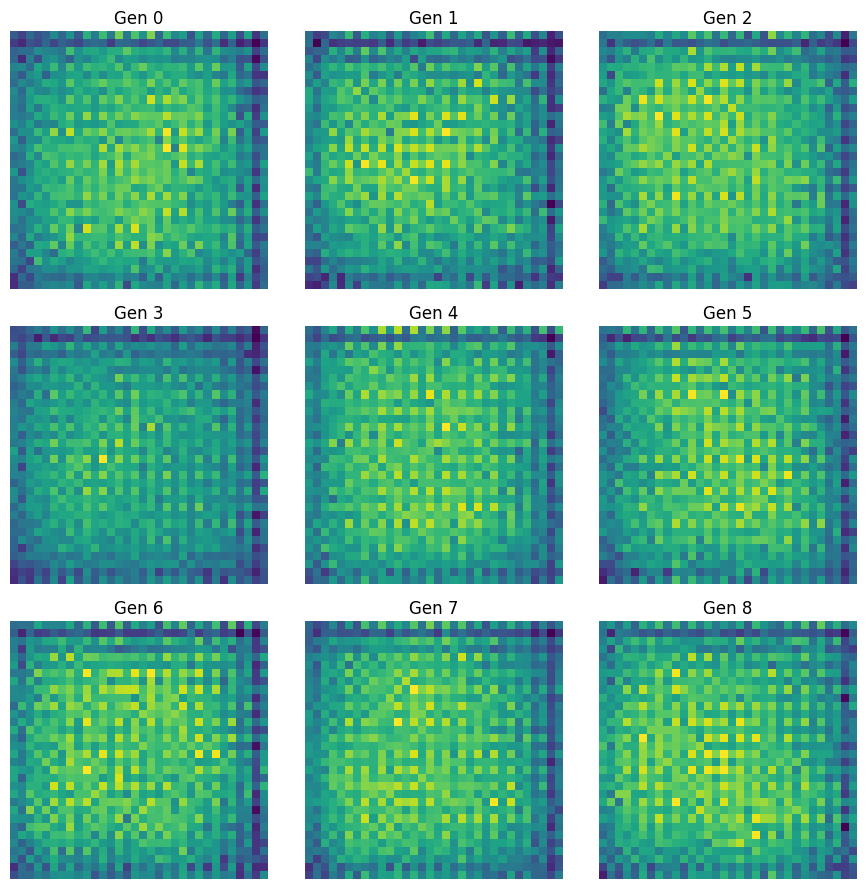

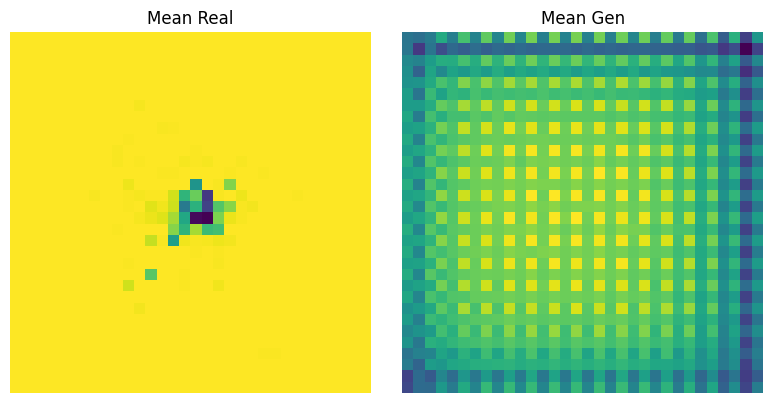

In [21]:
n_generate = 100

ckpt_path = 'saved_models/ddpm_unet_simple.pth'
state = torch.load(ckpt_path, map_location=device)
model_ddpm.load_state_dict(state)
model_ddpm.to(device)

gen = sample(model_ddpm, n_generate).cpu()
gen_np = gen.permute(0,2,3,1).numpy()  # (N,H,W,C)

# Prepare real samples for comparison (ensure shape (N,H,W,C))
if isinstance(encoded_data, torch.Tensor):
    real_np = encoded_data[:n_generate].cpu().numpy()
else:
    real_np = np.array(encoded_data[:n_generate])

# Fix channel ordering if needed (try to make last axis channels)
if real_np.ndim == 4 and real_np.shape[1] == gen_np.shape[-1]:
    # currently (N,C,H,W) -> convert to (N,H,W,C)
    real_np = real_np.transpose(0,2,3,1)
elif real_np.ndim == 3:
    real_np = real_np[..., np.newaxis]

print('generated:', gen_np.shape, 'real:', real_np.shape)

mu_r, sig_r = calculate_statistics(real_np)
mu_g, sig_g = calculate_statistics(gen_np)
fid_score = calculate_fid(mu_r, sig_r, mu_g, sig_g)

ssim_scores = []
m = min(len(real_np), len(gen_np))
for i in range(m):
    real_gray = np.mean(real_np[i], axis=2)
    gen_gray = np.mean(gen_np[i], axis=2)
    data_range = max(real_gray.max()-real_gray.min(), gen_gray.max()-gen_gray.min(), 1e-8)
    s = ssim_func(real_gray, gen_gray, data_range=float(data_range))
    ssim_scores.append(s)
avg_ssim = float(np.mean(ssim_scores)) if len(ssim_scores) > 0 else float('nan')

print(f'FID: {fid_score:.4f}, Mean SSIM: {avg_ssim:.4f}')

n_display = min(9, len(gen_np))
fig, axs = plt.subplots(3,3, figsize=(9,9))
for i in range(n_display):
    ax = axs[i//3, i%3]
    img = gen_np[i]
    if img.shape[-1] == 1:
        ax.imshow(img[...,0], cmap='viridis')
    else:
        ax.imshow(np.mean(img, axis=2), cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Gen {i}')
plt.tight_layout(); plt.show()

# Mean images
mean_real = np.mean(real_np[:m], axis=0)
mean_gen = np.mean(gen_np[:m], axis=0)
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(np.mean(mean_real, axis=2), cmap='viridis')
axs[0].set_title('Mean Real')
axs[0].axis('off')
axs[1].imshow(np.mean(mean_gen, axis=2), cmap='viridis')
axs[1].set_title('Mean Gen')
axs[1].axis('off')
plt.tight_layout(); plt.show()

# np.save('data/generated_samples_ddpm.npy', gen_np)

Postprocessed (invert + top-97%) FID: 64.2175, Mean SSIM: 0.3317


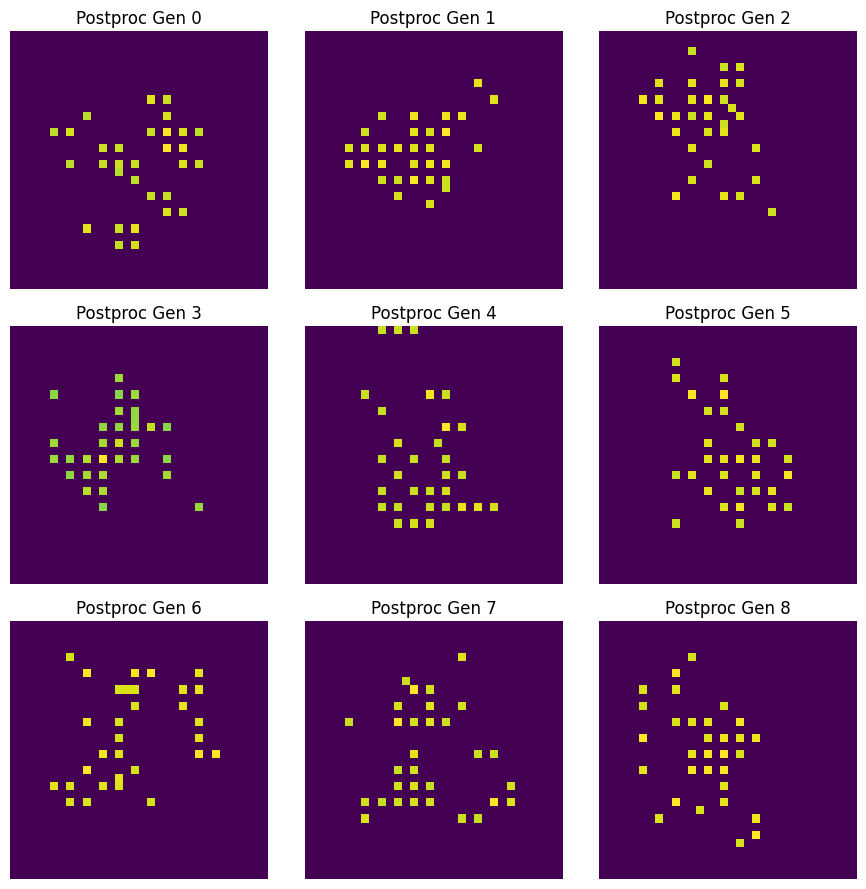

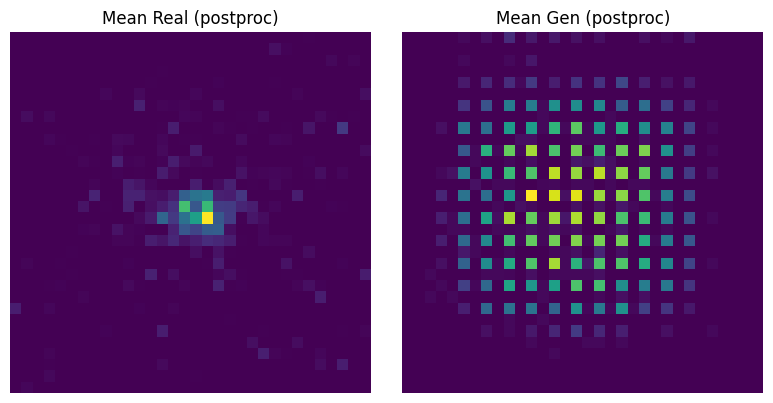

In [ ]:
gen = np.array(gen_np, dtype=np.float32)
real = np.array(real_np, dtype=np.float32)

def norm01(x):
    x = x.astype(np.float32)
    lo = x.min(axis=(1,2,3), keepdims=True)
    hi = x.max(axis=(1,2,3), keepdims=True)
    denom = (hi - lo)
    denom[denom==0] = 1.0
    return (x - lo) / denom

gen = norm01(gen)
real = norm01(real)
# Invert images (assumes brighter = jet; invert to emphasize jets if desired)
# inv_gen = np.clip(1.0 - gen, 0.0, 1.0)
inv_gen = gen
inv_real = np.clip(1.0 - real, 0.0, 1.0)

percentile = 97
def keep_top_percent(images, pct=90):
    out = np.zeros_like(images)
    for i in range(images.shape[0]):
        img = images[i]
        if img.ndim == 3:
            gray = img.mean(axis=2)
        else:
            gray = img
        thr = np.percentile(gray, pct)
        mask = gray >= thr
        if images.ndim == 4 and images.shape[-1] > 1:
            mask3 = np.repeat(mask[:, :, np.newaxis], images.shape[-1], axis=2)
        else:
            mask3 = mask[:, :, np.newaxis] if images.ndim==4 else mask
        out[i] = images[i] * mask3
    return out
proc_gen = keep_top_percent(inv_gen, percentile)
proc_real = keep_top_percent(inv_real, percentile)

mu_r, sig_r = calculate_statistics(proc_real)
mu_g, sig_g = calculate_statistics(proc_gen)
fid_score = calculate_fid(mu_r, sig_r, mu_g, sig_g)

ssim_scores = []
m = min(len(proc_real), len(proc_gen))
for i in range(m):
    real_gray = proc_real[i].mean(axis=2) if proc_real.ndim==4 else proc_real[i]
    gen_gray = proc_gen[i].mean(axis=2) if proc_gen.ndim==4 else proc_gen[i]
    data_range = max(real_gray.max()-real_gray.min(), gen_gray.max()-gen_gray.min(), 1e-8)
    s = ssim_func(real_gray, gen_gray, data_range=float(data_range))
    ssim_scores.append(s)
avg_ssim = float(np.mean(ssim_scores)) if len(ssim_scores)>0 else float('nan')
print(f'Postprocessed (invert + top-{percentile}%) FID: {fid_score:.4f}, Mean SSIM: {avg_ssim:.4f}')

# Plot a grid of postprocessed generated samples
import matplotlib.pyplot as plt
n_display = min(9, proc_gen.shape[0])
fig, axs = plt.subplots(3,3, figsize=(9,9))
for i in range(n_display):
    ax = axs[i//3, i%3]
    img = proc_gen[i]
    if img.shape[-1] == 1:
        ax.imshow(img[...,0], cmap='viridis')
    else:
        ax.imshow(np.mean(img, axis=2), cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Postproc Gen {i}')
plt.tight_layout(); plt.savefig('plots/postprocessed_gen_samples.png', dpi=200); plt.show()

# Plot mean images side-by-side
mean_real = np.mean(proc_real[:m], axis=0)
mean_gen = np.mean(proc_gen[:m], axis=0)
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(np.mean(mean_real, axis=2), cmap='viridis')
axs[0].set_title('Mean Real (postproc)')
axs[0].axis('off')
axs[1].imshow(np.mean(mean_gen, axis=2), cmap='viridis')
axs[1].set_title('Mean Gen (postproc)')
axs[1].axis('off')
plt.tight_layout(); plt.savefig('plots/postprocessed_mean.png', dpi=200); plt.show()